In [95]:
## importing the relevant packages:

# clear the workspace
%reset -f

# print list of files in directory
import os
print(os.listdir())

# print/display all plots inline
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# the base packages
import collections # for the Counter function
import csv # for reading/writing csv files
import pandas as pd, numpy as np, time, gc, bisect

# the various packages/modules used across processing (sklearn), modelling (lightgbm) and bayesian optimization (hyperopt, bayes_opt)
import sklearn
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn import metrics, preprocessing, decomposition
from sklearn.cross_validation import cross_val_score, StratifiedKFold, StratifiedShuffleSplit
from sklearn.base import TransformerMixin
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
import category_encoders as ce

from bayes_opt import BayesianOptimization
from tqdm import tqdm
from hyperopt import hp, tpe, STATUS_OK, fmin, Trials
from hyperopt.fmin import fmin
from hyperopt.pyll.stochastic import sample

# modelling algorithms
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV, VarianceThreshold

# Evaluation of the model
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from timeit import default_timer as timer

# Exporting packages for SHAP/LIME
import shap
import lime
import lime.lime_tabular

# missing value imputation
from fancyimpute import KNN, MICE #, NuclearNormMinimization

# define the global variables used later
MAX_EVALS = 10 # number of iterations/parameter sets created towards tuning
N_FOLDS = 5 # number of cv folds
randomseed = 1 # the value for the random state used at various points in the pipeline
pd.options.display.max_rows = 1000 # specify if you want the full output in cells rather the truncated list
pd.options.display.max_columns = 200

['.ipynb_checkpoints', '.svn', '2. Target Risk Analysis - Univariates, Bivariates and Missing Value Treatment.py', '3 month iteration results', 'archive', 'AUTOML_BC-Copy1.ipynb', 'AUTOML_BC.ipynb', 'AUTOML_BC_best.ipynb', 'backup.out.bak', 'backup.out.dir', 'backup_bne.pickle', 'backup_le.pickle', 'backup_le_2.pickle', 'barplots.ipynb', 'branches', 'EDA_NB.ipynb', 'FEATURE_ENGINEERING.ipynb', 'final_distribution.png', 'friday_meeting.csv', 'JUNE18_TURNOVER.xlsx', 'MAIN.ipynb', 'MAIN_best.ipynb', 'MAIN_best2.ipynb', 'Missing Data Imputation.ipynb', 'MODEL INTERPRETER.ipynb', 'MODEL_SELECTION_TUNING_TEST_2017Dec_model3.ipynb', 'MODEL_TOP_FEATURES_DISTRIBUTION_Graphs.ipynb', 'NAZ_missing_distribution.csv', 'New folder', 'OTHER_MODELS.ipynb', 'p.csv', 'pred.csv', 'preparation', 'PREPARATION.ipynb', 'salary_bonus_2017.csv', 'snippets', 'stacking_ensemble', 'tags', 'test2.csv', 'test3.csv', 'test_final.csv', 'train_dec2017.csv', 'train_final.csv', 'train_final_ext_1.csv', 'train_final_ext_2

In [76]:
#### MAIN CLASSES ####

## Two defined for now ##
# 1. DataFrame Imputer
#    - for imputing missing values
# 2. Prepare Data
#    - for sourcing, processing, and returning the train/valid datasets

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.
        Columns of dtype object are imputed with the most frequent value 
        in column.
        Columns of other types are imputed with mean of column.
        """
        
    def fit(self, X, y=None):
        X.groupby(['pay scale group', 'abinbev entity2'])
        self.fill = pd.Series([X[c].value_counts().index[0] if X[c].dtype == np.dtype('O') else X[c].mean() for c in X], 
                              index=X.columns)
        X.groupby('abinbev entity2')
        self.fill = pd.Series([X[c].value_counts().index[0] if X[c].dtype == np.dtype('O') else X[c].mean() for c in X], 
                              index=X.columns)
        X.reset_index(drop=True)
        self.fill = pd.Series([X[c].value_counts().index[0] if X[c].dtype == np.dtype('O') else X[c].mean() for c in X], 
                              index=X.columns)
        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)
    
    def num_missing(self):
        return sum(self.isnull())
    
    def imputer_method(self, column, method=['mean', 'median', 'most_frequent']):
        x = Imputer(missing_values = 'NaN', strategy = method, axis = 0)
        return x.fit_transform(self[[column]]).ravel()
    
    def fancy_impute(X, which_method):
        """ currently supported algorithms are KNN, NNM and MICE from the fancyimpute package
        which_method = ['KNN', 'NNM', 'MICE']
        """
        print(which_method, ' based missing value imputation is happening ...', '\n')
        
        if which_method == 'NNM': X = NuclearNormMinimization().complete(X) # NNM method
        if which_method == 'KNN': X = KNN(k=5, verbose=False).complete(X) # KNN method
        if which_method == 'MICE':
            X_complete_df = X.copy()
            mice = MICE(verbose=False)
            X_complete = mice.complete(np.asarray(X.values, dtype=float))
            X_complete_df.loc[:, X.columns] = X_complete[:][:]
            X = X_complete_df
        print('missing value imputation completed', '\n')
        return X

class prepare_data():
    
    def __init__(self):
        """ To prepare data,
                1. read in data
                2. pre-processing/cleaning
                3. creating helper objects for later steps
                4. processing for modelling
                5. function return objects are the train, valid, response, categ cols/indices, feature names
        """
    
    def labelEncoder(train_df, valid_df, categorical_names):
        print('label encoding is happening ...', '\n')
        cat_columns = train_df.select_dtypes(include=['object']).columns.values        
        for feature in tqdm(cat_columns):
            le = preprocessing.LabelEncoder()
            le.fit(train_df[feature].astype(str))
            train_df[feature] = le.transform(train_df[feature].astype(str))
            valid_df[feature] = valid_df[feature].map(lambda i: 'No Data' if i not in le.classes_ else i)
            le_classes = le.classes_.tolist()
            bisect.insort_left(le_classes, 'No Data')
            le.classes_ = le_classes
            valid_df[feature] = le.transform(valid_df[feature].astype(str))
            categorical_names[feature] = le.classes_
        print('label encoding completed', '\n')
        return train_df, valid_df, categorical_names
        
    def ce_encodings(train_df, valid_df, y_train, y_valid, encoding):
        print('category encoding is happening ...', '\n')
        if encoding=='bne':          
            enc=ce.BaseNEncoder(base=3)
        elif encoding=='be':
            enc=ce.BinaryEncoder()
        elif encoding=='he':
            enc=ce.HashingEncoder()
        elif encoding=='oe':
            enc=ce.OrdinalEncoder()
        elif encoding=='ohe':
            enc=ce.BaseNEncoder(base=1)
        enc.fit(train_df)
        train_df=enc.transform(train_df)
        valid_df=enc.transform(valid_df)
        print('category encoding completed', '\n')
        return train_df, valid_df
    
    ## function to get frequency count of elements in a vector/list
    def freq_count(input_vector):
        return collections.Counter(input_vector)
    
    def categ_feats(train_df, valid_df, y_train, y_valid, encoding='le'):
        x = list(train_df.dtypes)
        x_1 = [1 if x == 'O' else 0 for x in x]
        categorical_idx = [i for i, x in enumerate(x_1) if x == 1]
        # Get feature names and their values for categorical data (needed for LIME)
        cat_columns = train_df.select_dtypes(include=['object']).columns.values
        categorical_names = {}

        train_df, valid_df = prepare_data.categ_feat_eng(train_df, valid_df, cat_columns)

        train_df = train_df.drop(['label'], axis = 1)
        valid_df = valid_df.drop(['label'], axis = 1)

        train_df_cat = train_df[cat_columns]
        num_cols = list(set(train_df.columns)-set(train_df_cat.columns))
        train_df_num = train_df[num_cols]
        valid_df_cat = valid_df[cat_columns]
        valid_df_num = valid_df[num_cols]
                
        if encoding=='le':
            train_df_cat, valid_df_cat, categorical_names = prepare_data.labelEncoder(train_df_cat, valid_df_cat, categorical_names)
        elif encoding in ['be', 'bne', 'he', 'oe', 'ohe']:
            train_df_cat, valid_df_cat = prepare_data.ce_encodings(train_df_cat, valid_df_cat, y_train, y_valid, encoding)
        else :
            print('Not supported. Use one of [be, bne, he, oe, ohe]', '\n')
        
        train = pd.concat([train_df_cat.reset_index(drop=True), train_df_num], axis=1)
        valid = pd.concat([valid_df_cat.reset_index(drop=True), valid_df_num], axis=1)
        
        print('encoding completed ...', '\n')

        return train, valid, categorical_names, categorical_idx
    
    def categ_feat_eng(train_df, valid_df, cat_columns):
        print('categorical feature engineering is happening ...', '\n')
        
        global iter
        iter = 0
        for i in tqdm(cat_columns):
            grouped_df = pd.DataFrame(train_df.groupby([i])['label'].agg(['mean', 'std'])).reset_index()
            grouped_df.rename(columns={'mean': str('mean_' + cat_columns[iter]),
                                       'std': str('std_' + cat_columns[iter])}, inplace=True)
            train_df = pd.merge(train_df, grouped_df, how='left')
            valid_df = pd.merge(valid_df, grouped_df, how='left')
            iter += 1
        return train_df, valid_df
    
    def datetime_feats(train, valid, cols):
        """ contains a nested function that creates several time dimension features from the datetime columns passed """
        print('datetime feature engineering is happening ...', '\n')
        
        def dt_feats(df, col):
            df[col] = pd.to_datetime(df[i])
            #df[str(col+'_'+'day')] = df[col].dt.day
            df[str(col+'_'+'day_name')] = df[col].dt.day_name
            #df[str(col+'_'+'dayofweek')] = df[col].dt.dayofweek
            df[str(col+'_'+'dayofyear')] = df[col].dt.dayofyear
            #df[str(col+'_'+'days_in_month')] = df[col].dt.days_in_month
            df[str(col+'_'+'month')] = df[col].dt.month
            df[str(col+'_'+'month_name')] = df[col].dt.month_name
            df[str(col+'_'+'quarter')] = df[col].dt.quarter
            df[str(col+'_'+'week')] = df[col].dt.week
            #df[str(col+'_'+'weekday')] = df[col].dt.weekday
            df[str(col+'_'+'year')] = df[col].dt.year
            #df[col] = df[col].dt.date
            df = df.drop([col], axis = 1)
            return df
        for i in cols:
            train = dt_feats(train, i)
            valid = dt_feats(valid, i)
        return train, valid
    
    def create(input_file_path, input_file_path_2, input_file_path_3, response, cols_to_remove = ['id'], random_seed = 1,
                            encoding = 'le'):        
        train = pd.read_csv(input_file_path, na_values=['No Data', ' ', 'UNKNOWN'])
        test = pd.read_csv(input_file_path_3, na_values=['No Data', ' ', 'UNKNOWN'])
        valid = pd.read_csv(input_file_path_2, na_values=['No Data', ' ', 'UNKNOWN'])
        train_ext_1 = pd.read_csv('train_final_ext_2.csv', na_values=['No Data', ' ', 'UNKNOWN'])
        
        # remove all the columns specified by user
        train.drop(cols_to_remove, axis = 1, inplace = True)
        valid = pd.DataFrame(data = valid[train.columns])
        test = pd.DataFrame(data = test[train.columns])
        train_ext_1 = pd.DataFrame(data = train_ext_1[train.columns])
        
        # clean the column names
        chars_to_remove = [' ', '.', '(', ')', '__', '-']
        for i in chars_to_remove:
            train.columns = train.columns.str.strip().str.lower().str.replace(i, '_')
            valid.columns = valid.columns.str.strip().str.lower().str.replace(i, '_')
            test.columns = test.columns.str.strip().str.lower().str.replace(i, '_')
            train_ext_1.columns = train_ext_1.columns.str.strip().str.lower().str.replace(i, '_')
        
        print('original train df shape is: ', train.shape, '\n')

        train = train.append(pd.DataFrame(data = test), ignore_index=True)
        train = train.append(pd.DataFrame(data = train_ext_1), ignore_index=True)
        print('new train df shape is: ', train.shape, '\n')
        
        # creating the datetime features from the datetime columns
        cols = [s for s in train.columns.values if 'date' in s]        
        train, valid = prepare_data.datetime_feats(train, valid, cols)
        
        # missing value threshold control (for both rows and columns)
        print(train.shape, '\n')
        train.dropna(thresh=0.6*(train.shape[0]), axis=1, inplace = True)
        train.dropna(thresh=0.6*(train.shape[1]), axis=0, inplace = True)
        print(train.shape, '\n')
        valid = valid[train.columns]
        valid.dropna(thresh=0.6*(valid.shape[0]), axis=1, inplace = True)
        train = train[valid.columns]
                
        # reset the index since inplace operations happened earlier
        train.index = pd.RangeIndex(len(train.index))
        valid.index = pd.RangeIndex(len(valid.index))
        
        valid_ids = valid[['original_id', 'label']]
        valid_ids.to_csv('valid_dfs.csv', index=False)
        valid.drop('original_id', axis=1, inplace=True)
        train.drop('original_id', axis=1, inplace=True)
        
        # the class balance in the training dataset for the response
        print(prepare_data.freq_count(train[response]), '\n')

        # shuffle the dataframes so that the training is done in a random order.
        #X_train = pd.DataFrame(shuffle(train))
        #X_valid = pd.DataFrame(shuffle(valid))
        X_train = pd.DataFrame(train)
        X_valid = pd.DataFrame(valid)
        
        # creating the response vector
        y_train = X_train[response].values
        y_valid = X_valid[response].values
        
        X_train, X_valid, categ_names, categ_idx = prepare_data.categ_feats(X_train, X_valid, y_train, y_valid, encoding)

        # remove highly correlated features to reduce further computation time
        print('correlation analysis is happening ...', '\n')
        # Create correlation matrix
        corr_matrix = X_train.corr().abs()
        # Select upper triangle of correlation matrix
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
        # Find index of feature columns with correlation greater than 0.8
        to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]        
        # Drop features
        print(to_drop, '\n')
        X_train.drop(to_drop, axis=1, inplace=True)
        X_valid.drop(to_drop, axis=1, inplace=True)
        
        # store all feature names
        feat_names = X_train.columns.values
        feat_names2 = X_valid.columns.values
        
        # missing value imputation
        X_train = DataFrameImputer.fancy_impute(X_train, which_method='KNN')
        X_valid = DataFrameImputer.fancy_impute(X_valid, which_method='KNN')
        
        # returning as pandas dataframes to retain feature names for LIME and feature importance plots
        X_train = pd.DataFrame(data=X_train, columns=feat_names)
        X_valid = pd.DataFrame(data=X_valid, columns=feat_names2)
        
        return X_train, X_valid, y_train, y_valid, categ_names, categ_idx, feat_names

In [8]:
# create data function call
# CV approach
# train and valid features/response dataframes returned
# categorical column names/indices and all feature names also returned

X_train, X_valid, y_train, y_valid, categ_names, categ_idx, feat_names = prepare_data.create(input_file_path='train_final.csv',
                                                                  input_file_path_2='valid_final.csv', input_file_path_3='test_final.csv',
                                                                                             response = 'label',
                                cols_to_remove = ['global id', 'pers. subarea text',
                                                  'manager global id', 'personnel number manager', 
                                                  'short text of organizational unit', 'position text', 
                                                  'physical work location-description', 'physical work location-city',
                                                  'manager position desc', 'costcenter description',
                                                  'local entity description', 'appraiser id', 'time in position'], encoding = 'le')

original train df shape is:  (6102, 79) 

new train df shape is:  (12181, 79) 

datetime feature engineering is happening ... 

(12181, 91) 

(10701, 89) 

Counter({0: 10059, 1: 642}) 

categorical feature engineering is happening ... 



100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:10<00:00,  4.11it/s]


label encoding is happening ... 



  0%|                                                                                           | 0/45 [00:00<?, ?it/s]C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

label encoding completed 

encoding completed ... 

correlation analysis is happening ... 

['job_family', 'functional_area', 'g_total_comparison', 'gender_relation', 'target_by_cost_center', 'target_by_org_id', 'target_by_aid_band', 'target_by_me_band', 'target_by_fa_band', 'target_by_cc_band', 'target_by_oid_band', 'gt_percentage_team2', 'std_macro_entity_type', 'mean_target_by_band', 'original_hire_date_quarter', 'ebm_level_of_the_job', 'position_start_date_month', 'mean_m_gender', 'mean_manager_pay_scale', 'std_target_by_cc_band', 'bt_percentage_team2', 'annual_salary', 'mean_target_by_appraiser', 'mean_g_total_comparison_team', 'original_hire_date_dayofyear', 'std_target_by_fa_band', 'gt_percentage_team', 'position_start_date_dayofyear', 'mean_cr_team2', 'mean_original_hire_date_day_name', 'service_months', 'mean_opr_2', 'mean_original_hire_date_month_name', 'std_target_by_org_id', 'std_original_hire_date_day_name', 'std_bonus_comparison_team', 'std_target_by_aid_band', 'std_incen

In [77]:
import pickle

# f = open("backup_le_2.pickle", "wb")
# pickle.dump(X_train, f)
# pickle.dump(X_valid, f)
# pickle.dump(y_train, f)
# pickle.dump(y_valid, f)
# f.close()

f = open("backup_le.pickle", "rb")
X_train = pickle.load(f)
X_valid = pickle.load(f)
y_train = pickle.load(f)
y_valid = pickle.load(f)
f.close()

#################################################################################################################################

print(X_train.shape)
#print(X_test.shape)
print(X_valid.shape)

print(y_train.shape)
#print(y_test.shape)
print(y_valid.shape)

print(collections.Counter(y_train))
#print(collections.Counter(y_test))
print(collections.Counter(y_valid))

(16215, 91)
(5734, 91)
(16215,)
(5734,)
Counter({0: 15557, 1: 658})
Counter({0: 5453, 1: 281})


## FEATURE ENGINEERING MODULE

- Decomposition features
    - PCA
    - ICA
    - TSVD
    - GRP
    - SRP
    - ...
- Clustering output feaatures
    - KMeans
    - ...
- Deterministic features
    - Binning
    - ...

In [78]:
class feat_eng():
    
    def __init__():
        """ this module contains several functions for creating new features. find below a brief description of each """
    
    def scalers(train, valid, which_method):
        if which_method == 'ss':
            sc = StandardScaler()
            sc.fit(train)
            train = pd.DataFrame(sc.transform(train), columns=train.columns.values)
            valid = pd.DataFrame(sc.transform(valid), columns=valid.columns.values)
            return train, valid # scale all variables to zero mean and unit variance, required for PCA and related
        if which_method == 'mm':
            mm = MinMaxScaler()
            mm.fit(train)
            train = pd.DataFrame(mm.transform(train), columns=train.columns.values)
            valid = pd.DataFrame(mm.transform(valid), columns=train.columns.values)
            return train, valid # use this method to iterate
    
    def decomp_various():
        return None
    
    def pca_feats(train, valid, n = .95):
            train, valid = feat_eng.scalers(train, valid, which_method='ss')
            pca_fit = decomposition.PCA(n_components=n)
            pca_fit.fit(train)
            pca_train = pd.DataFrame(pca_fit.transform(train))
            pca_valid = pd.DataFrame(pca_fit.transform(valid))
            pca_cols = list(set(list(pca_train)))
            pca_cols = ['pca_' + str(s) for s in pca_cols]
            pca_train.columns = pca_cols
            pca_valid.columns = pca_cols
            return pca_train, pca_valid
        
    def ica_feats(train, valid, n = 5):
            train, valid = feat_eng.scalers(train, valid, which_method='ss')
            ica_fit = decomposition.FastICA(n_components=n)
            ica_fit.fit(train)
            ica_train = pd.DataFrame(ica_fit.transform(train))
            ica_valid = pd.DataFrame(ica_fit.transform(valid))
            ica_cols = list(set(list(ica_train)))
            ica_cols = ['ica_' + str(s) for s in ica_cols]
            ica_train.columns = ica_cols
            ica_valid.columns = ica_cols
            return ica_train, ica_valid
        
    def tsvd_feats(train, valid, n = 5):
            train, valid = feat_eng.scalers(train, valid, which_method='ss')
            tsvd_fit = decomposition.TruncatedSVD(n_components=n)
            tsvd_fit.fit(train)
            tsvd_train = pd.DataFrame(tsvd_fit.transform(train))
            tsvd_valid = pd.DataFrame(tsvd_fit.transform(valid))
            tsvd_cols = list(set(list(tsvd_train)))
            tsvd_cols = ['tsvd_' + str(s) for s in tsvd_cols]
            tsvd_train.columns = tsvd_cols
            tsvd_valid.columns = tsvd_cols
            return tsvd_train, tsvd_valid
        
    def grp_feats(train, valid, n = 5):
            train, valid = feat_eng.scalers(train, valid, which_method='ss')
            grp_fit = GaussianRandomProjection(n_components=n, eps=0.3)
            grp_fit.fit(train)
            grp_train = pd.DataFrame(grp_fit.transform(train))
            grp_valid = pd.DataFrame(grp_fit.transform(valid))
            grp_cols = list(set(list(grp_train)))
            grp_cols = ['grp_' + str(s) for s in grp_cols]
            grp_train.columns = grp_cols
            grp_valid.columns = grp_cols
            return grp_train, grp_valid
    
    def srp_feats(train, valid, n = 5):
            train, valid = feat_eng.scalers(train, valid, which_method='ss')
            srp_fit = SparseRandomProjection(n_components=n, dense_output=True, eps=0.3)
            srp_fit.fit(train)
            srp_train = pd.DataFrame(srp_fit.transform(train))
            srp_valid = pd.DataFrame(srp_fit.transform(valid))
            srp_cols = list(set(list(srp_train)))
            srp_cols = ['srp_' + str(s) for s in srp_cols]
            srp_train.columns = srp_cols
            srp_valid.columns = srp_cols
            return srp_train, srp_valid
        
    def return_combined(train, valid, list_objects = ['pca', 'ica', 'tsvd', 'grp', 'srp']):
        if 'pca' in list_objects:
            train = pd.concat([train.reset_index(drop=True), pca_train], axis=1)
            valid = pd.concat([valid.reset_index(drop=True), pca_valid], axis=1)
        if 'ica' in list_objects:
            train = pd.concat([train.reset_index(drop=True), ica_train], axis=1)
            valid = pd.concat([valid.reset_index(drop=True), ica_valid], axis=1)
        if 'tsvd' in list_objects:
            train = pd.concat([train.reset_index(drop=True), tsvd_train], axis=1)
            valid = pd.concat([valid.reset_index(drop=True), tsvd_valid], axis=1)
        if 'grp' in list_objects:
            train = pd.concat([train.reset_index(drop=True), grp_train], axis=1)
            valid = pd.concat([valid.reset_index(drop=True), grp_valid], axis=1)
        if 'srp' in list_objects:
            train = pd.concat([train.reset_index(drop=True), srp_train], axis=1)
            valid = pd.concat([valid.reset_index(drop=True), srp_valid], axis=1)
        return train, valid

In [79]:
## calling the various feat engineering functions and adding those features
## pca, ica, tsvd, grp, srp
pca_train, pca_valid = feat_eng.pca_feats(train=X_train, valid=X_valid, n=.95)
ica_train, ica_valid = feat_eng.ica_feats(train=X_train, valid=X_valid, n=5)
tsvd_train, tsvd_valid = feat_eng.tsvd_feats(train=X_train, valid=X_valid, n=5)
grp_train, grp_valid = feat_eng.grp_feats(train=X_train, valid=X_valid, n=5)
srp_train, srp_valid = feat_eng.srp_feats(train=X_train, valid=X_valid, n=5)

## scale the data
X_train, X_valid = feat_eng.scalers(train=X_train, valid=X_valid, which_method='ss')

## return the final datasets with the added features
X_train, X_valid = feat_eng.return_combined(train = X_train, valid = X_valid)

C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


In [80]:
## k-means clustering features

from sklearn.cluster import KMeans

class kmeans_feats():
    def __init__():
        """ module for adding features based on kmeans clusters generated """
    
    def clusterer(train_df, valid_df, n):
        clusterer = KMeans(n, random_state=1, init='k-means++')
        
        # fit the clusterer
        clusterer.fit(train_df)
        
        train_clusters = clusterer.predict(train_df)
        valid_clusters = clusterer.predict(valid_df)
        
        return train_clusters, valid_clusters
    
    def combine(train_df, valid_df, m=5):
        for i in range(2, m):
            t, v = kmeans_feats.clusterer(train_df, valid_df, n=i)
            col_name = str('kmeans_'+ str(i))
            t = pd.DataFrame({col_name: t})
            v = pd.DataFrame({col_name: v})
            
            train_df = pd.concat([train_df.reset_index(drop=True), t], axis=1)
            valid_df = pd.concat([valid_df.reset_index(drop=True), v], axis=1)
            
        return train_df, valid_df

In [81]:
X_train, X_valid = kmeans_feats.combine(X_train, X_valid, m=10)

In [82]:
## FEATURE SELECTION

class feat_selection():
    
    def __init__():
        """ this module is for dynamic feature selection after all the processing and feat engineering phases. ideally this
        module is followed by the modelling phase immediately """

    # removing near zero variance columns
    def variance_threshold_selector(train, valid, threshold):
        print('input data shape is: ', train.shape, '\n')
        selector = VarianceThreshold(threshold)
        selector.fit(train)
        X = train[train.columns[selector.get_support(indices=True)]]
        Y = valid[valid.columns[selector.get_support(indices=True)]]
        #display(pd.DataFrame(X.head(5)))
        print('output data shape is: ', X.shape, '\n')
        return X, Y

    # using RFECV
    def rfecv(train, valid, y_train):
        # Create the RFE object and compute a cross-validated score.
        #model = LogisticRegression(C=0.1, penalty='l1')
        model = RandomForestClassifier(max_depth=7, max_features=0.25, n_estimators=100, n_jobs=1)
        rfecv = RFECV(estimator=model, step=5, scoring='roc_auc', verbose=True)
        rfecv.fit(train, y_train)

        print("Optimal number of features : %d" % rfecv.n_features_)

        # Plot number of features VS. cross-validation scores
#         plt.figure()
#         plt.xlabel("Number of features selected")
#         plt.ylabel("Cross validation score (roc-auc)")
#         plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
#         plt.show()

        features = [f for f,s in zip(train.columns, rfecv.support_) if s]
        train = train[features]
        valid = valid[features]
        return train, valid
    
    def feat_selection(train, valid, y_t, t=0.1):
        # read in the train, valid and y_train objects
        X, Y = feat_selection.variance_threshold_selector(train, valid, threshold=t)
        
        X, Y = feat_selection.rfecv(train=X, valid=Y, y_train=y_t)
        
        return X, Y

input data shape is:  (16215, 184) 

output data shape is:  (16215, 174) 

Fitting estimator with 174 features.
Fitting estimator with 169 features.
Fitting estimator with 164 features.
Fitting estimator with 159 features.
Fitting estimator with 154 features.
Fitting estimator with 149 features.
Fitting estimator with 144 features.
Fitting estimator with 139 features.
Fitting estimator with 134 features.
Fitting estimator with 129 features.
Fitting estimator with 124 features.
Fitting estimator with 119 features.
Fitting estimator with 114 features.
Fitting estimator with 109 features.
Fitting estimator with 104 features.
Fitting estimator with 99 features.
Fitting estimator with 94 features.
Fitting estimator with 89 features.
Fitting estimator with 84 features.
Fitting estimator with 79 features.
Fitting estimator with 74 features.
Fitting estimator with 69 features.
Fitting estimator with 64 features.
Fitting estimator with 59 features.
Fitting estimator with 54 features.
Fitting es

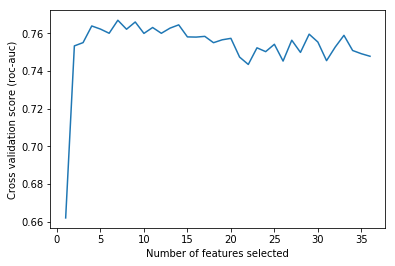

In [53]:
X_train, X_valid = feat_selection.feat_selection(train=X_train, valid=X_valid, y_t=y_train, t=0.1)

In [83]:
X_train, X_valid = feat_selection.variance_threshold_selector(train=X_train, valid=X_valid, threshold=0.1)

input data shape is:  (16215, 184) 

output data shape is:  (16215, 174) 



In [84]:
""" Explicitly doing sampling. Use with care if going ahead with the CV based approach. Keep ratio low if so (recommended)

oversampling the minority class using techniques from SMOTE (for oversampling) and ENN/Tomek (for undersampling/cleaning)
ENN worked out better than Tomek
added support for undersampling with ENN/RENN/AllKNN """

from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import AllKNN, EditedNearestNeighbours, RepeatedEditedNearestNeighbours

feat_names = X_train.columns.values

### OVERSAMPLING (ADASYN) ###
    # Apply ADASYN
# ada = ADASYN(random_state=0)
# X_train, y_train = ada.fit_sample(X_train, y_train)

### OVERSAMPLING (SMOTE) AND THEN UNDERSAMPLING (ENN/Tomek) ###
    # Apply SMOTE + Tomek links
# sm = SMOTETomek(random_state=0, ratio=0.75)
# X_train, y_train = sm.fit_sample(X_train, y_train)
    # Apply SMOTE + ENN
smote_enn = SMOTEENN(random_state=0, ratio=0.5)
X_train, y_train = smote_enn.fit_sample(X_train, y_train)

### UNDERSAMPLING (ENN/RENN/AllKNN) ###
    # Apply ENN
# enn = EditedNearestNeighbours(random_state=0)
# X_train, y_train = enn.fit_sample(X_train, y_train)
    # Apply RENN
# renn = RepeatedEditedNearestNeighbours(random_state=0)
# X_train, y_train = renn.fit_sample(X_train, y_train)
    # Apply AllKNN
# allknn = AllKNN(random_state=0)
# X_train, y_train = allknn.fit_sample(X_train, y_train)

X_train = pd.DataFrame(data=X_train,columns=feat_names)

print(X_train.shape, y_train.shape, collections.Counter(y_train))

C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


(18937, 174) (18937,) Counter({0: 11170, 1: 7767})


In [85]:
""" XGBOOST """

' XGBOOST '

In [86]:
## xgboost class for tuning parameters and returning the best model

class xgboost_model():
    
    def __init__():
        """ this class initializes some functions used in the xgboost pipeline """
    
    # define your custom evaluation metric here
    # currently defined: recall, precision, f1, roc-auc, weighted of recall/precision metrics
    def f1_score(preds, dtrain):
        labels = dtrain.get_label()
        #y_preds = [1 if y >= 0.5 else 0 for y in preds] # binaryzing your output
        #rscore = sklearn.metrics.recall_score(y_pred=y_preds, y_true=labels)
        #pscore = sklearn.metrics.precision_score(y_pred=y_preds, y_true=labels)
        #score = sklearn.metrics.f1_score(y_pred=y_preds, y_true=labels)
        score = sklearn.metrics.roc_auc_score(y_score=preds, y_true=labels)
        #score = (4*rscore + pscore)/5
        return 'score', score
    
    # function to be minimized and sent to the optimize function of hyperopt
    def xgb_score(params):
        global ITERATION
        ITERATION += 1
        randomseed = 1
        
        # Make sure parameters that need to be integers are integers
        for parameter_name in ['max_depth', 'scale_pos_weight']:
            params[parameter_name] = int(params[parameter_name])
                    
        dtrain = xgb.DMatrix(data=X_train.values, feature_names=X_train.columns.values, label=y_train)
        xgb_cv = xgb.cv(params = params, num_boost_round=1000, nfold=N_FOLDS, dtrain=dtrain, early_stopping_rounds=5,
                       feval = xgboost_model.f1_score, maximize = True, stratified = True, verbose_eval=False) # may tune on the stratified flag
        num_rounds = len(xgb_cv['test-score-mean'])
        bst_score = xgb_cv['test-score-mean'][num_rounds-1]
        #print('evaluation metric score of iteration is: ', bst_score, '\n')
        return {'loss': (1 - bst_score), 'status': STATUS_OK, 'params': params, 'num_boost': num_rounds, 
                'bst_score': bst_score, 'base_score': params['base_score']}
    
    # function to do hyperparameter tuning with hyperopt (bayesian based method)
    def optimize(X_train, y_train):
        # Keep track of evals
        global ITERATION
        ITERATION = 0
        global trials
        trials = Trials()
        
        # space to be traversed for the hyperopt function
        space = {
            'base_score' : hp.quniform('base_score', 0.1, 0.9, 0.01),
             'learning_rate' : hp.uniform('learning_rate', 0.001, 0.2),
             #'max_depth' : hp.choice('max_depth', np.arange(3, 8, dtype=int)),
            'max_depth' : hp.quniform('max_depth', 5, 20, 1),
             'min_child_weight' : hp.quniform('min_child_weight', 0, 5, 0.2),
             'subsample' : hp.quniform('subsample', 0.7, 0.85, 0.05),
             'gamma' : hp.quniform('gamma', 0, 1, 0.1),
            'reg_lambda' : hp.uniform ('reg_lambda', 0, 1),
             'colsample_bytree' : hp.quniform('colsample_bytree', 0.7, 0.85, 0.05),
            'scale_pos_weight' : hp.quniform('scale_pos_weight', 1, 5, 1),
            'objective' : 'binary:logistic'}
        
        best = fmin(xgboost_model.xgb_score, space, algo=tpe.suggest, trials=trials, max_evals=MAX_EVALS,
                    rstate=np.random.RandomState(randomseed))
        best = trials.best_trial['result']['params']
        num_rounds = trials.best_trial['result']['num_boost']
        
        return trials, best, num_rounds # results of all the iterations, the best one and the number of rounds for the best run
    
    # train and return a model with the best params
    def xgb_train(best_params, num_rounds):
        dtrain = xgb.DMatrix(data=X_train.values, feature_names=X_train.columns.values, label=y_train)
        model = xgb.train(best_params, dtrain=dtrain, maximize=True, num_boost_round=num_rounds, feval=xgboost_model.f1_score)
        return model

    # function to input a model and test matrix to output predictions and score parameters
    def xgb_predict(X_test, y_test, model, trials, mode = "validate", threshold = 0.2):
        dtest = xgb.DMatrix(data=X_test, feature_names=X_test.columns.values)
        pred = model.predict(dtest)
        #predict = np.where(pred > trials.best_trial['result']['base_score'], 1, 0)
        predict = np.where(pred > threshold, 1, 0)
        
        if mode == "validate":
            recall_score = sklearn.metrics.recall_score(y_pred=predict, y_true=y_test)
            precision_score = sklearn.metrics.precision_score(y_pred=predict, y_true=y_test)
            f1_score = sklearn.metrics.f1_score(y_pred=predict, y_true=y_test)
            auc_score = roc_auc_score(y_test, pred)
            tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_pred=predict, y_true=y_test).ravel()
            print(sklearn.metrics.confusion_matrix(y_pred=predict, y_true=y_test), '\n')
            print('recall score is: ', recall_score)
            print('precision score is: ', precision_score)
            print('f1_score is: ', f1_score)
            print('accuracy score: ', sklearn.metrics.accuracy_score(y_true=y_test, y_pred=predict))
            print('The final AUC after taking the best params and num_rounds when it stopped is {:.4f}.'.format(auc_score), '\n')
            return pred, predict, tn, fp, fn, tp
        else:
            return pred
        
    # function to return cv results for train dataset (recall/precision/f1/accuracy)
    def xgb_cv(X_train, y_train, best_params):
        model = xgb.XGBClassifier(**best, silent=True)
        xgb_cv_scores = sklearn.model_selection.cross_val_predict(model, X_train, y_train, cv=5)
        print('recall: ', sklearn.metrics.recall_score(y_pred=xgb_cv_scores, y_true=y_train))
        print('precision: ', sklearn.metrics.precision_score(y_pred=xgb_cv_scores, y_true=y_train))
        print('f1: ', sklearn.metrics.f1_score(y_pred=xgb_cv_scores, y_true=y_train))
        print('accuracy: ', sklearn.metrics.accuracy_score(y_pred=xgb_cv_scores, y_true=y_train))

In [87]:
""" calling the model creation functions to return the trials (results object) and the best parameters.
the best parameters are used to train the model and the predicted results are returned with the .xgb_predict call """

# return the trials and best parameters
trials, best, num_rounds = xgboost_model.optimize(X_train=X_train, y_train=y_train)
print('best score was: ', 1 - trials.average_best_error(), '\n')
#print(trials.best_trial['result']['bst_score'])

# return the model object trained with the best parameters
model = xgboost_model.xgb_train(best, num_rounds)

# uncomment below line if you went ahead with the train/test split approach over the CV based approach
#pred, predict, tn, fp, fn, tp = xgboost_model.xgb_predict(X_test=X_test, model=model, y_test=y_test, mode='validate', trials=trials)

best score was:  0.9981142000000001 



In [88]:
# cv results
xgboost_model.xgb_cv(X_train, y_train, best)

C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

recall:  0.9752800308999614
precision:  0.7662350799109853
f1:  0.8582110689401234
accuracy:  0.8678248930664836


In [94]:
xgb_pred, xgb_predict, tn, fp, fn, tp = xgboost_model.xgb_predict(X_test=X_valid, model=model, y_test=y_valid, mode='validate',
                                                                  trials=trials, threshold = 0.04)

[[2930 2523]
 [ 102  179]] 

recall score is:  0.6370106761565836
precision score is:  0.06624722427831237
f1_score is:  0.12001340931947703
accuracy score:  0.5422043948378096
The final AUC after taking the best params and num_rounds when it stopped is 0.6172. 



In [69]:
# xgb_pred, xgb_predict
valid_dfs = pd.read_csv('valid_dfs.csv')
TO_file = pd.read_excel('JUNE18_TURNOVER.xlsx')
TO_file = TO_file[['Global ID', 'Termination Month']]
TO_file.columns = ['original_id', 'term_month']

pred_df = pd.DataFrame(xgb_pred)
p = pd.concat([pred_df.reset_index(drop=True), pd.DataFrame(xgb_predict)], axis=1)
p.columns = ['prob', 'predict']

p['decile'] = pd.qcut(x=p['prob'], q=10, labels=False)
p = pd.concat([p.reset_index(drop=True), valid_dfs], axis=1)

p = pd.merge(p, TO_file, how='left')
#p=p[p['label'] == 1]

p.to_csv('p.csv', index=False)

In [60]:
print('true negatives: ', tn)
print('false positives: ', fp)
print('false negatives: ', fn)
print('true positives: ', tp)

true negatives:  2356
false positives:  3097
false negatives:  72
true positives:  209


In [ ]:
p, r, thresholds = metrics.precision_recall_curve(y_true=y_valid, probas_pred=xgb_pred)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    
plot_precision_recall_vs_threshold(p, r, thresholds)

In [70]:
import pickle

pickle.dump(model, open("xgb_june17.pickle.dat", "wb"))
#loaded_model = pickle.load(open("xgb_june17.pickle.dat", "rb"))

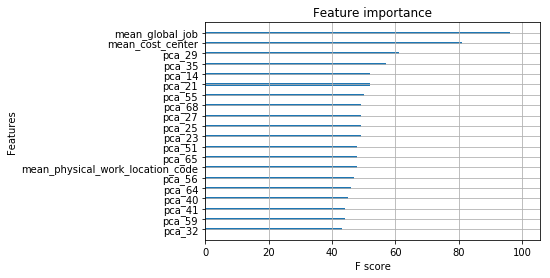

In [27]:
## important features from the best model above

xgb.plot_importance(booster=model, max_num_features=20, show_values=False)

In [21]:
""" LIGHTGBM """

' LIGHTGBM '

In [139]:
# lightgbm class for tuning

class lightgbm_model():
    
    def __init__():
        """ this class initializes some functions used in the lightgbm pipeline """
    
    def score(preds, train_set):
        labels = train_set.get_label()
        y_preds = [1 if y >= 0.5 else 0 for y in preds] # binaryzing your output

        rscore = sklearn.metrics.recall_score(y_pred=y_preds, y_true=labels)
        pscore = sklearn.metrics.precision_score(y_pred=y_preds, y_true=labels)
        #score = sklearn.metrics.f1_score(y_pred=y_preds, y_true=labels)
        #score = sklearn.metrics.roc_auc_score(y_score=y_preds, y_true=labels)
        score = (4*rscore + pscore)/5
        
        return 'score', score, True
    
    def lgbm_score(params):        
        global ITERATION
        ITERATION += 1
        
        # Retrieve the subsample if present otherwise set to 1.0
        subsample = params['boosting_type'].get('subsample', 1.0)
        # Extract the boosting type
        params['boosting_type'] = params['boosting_type']['boosting_type']
        params['subsample'] = subsample

        # Make sure parameters that need to be integers are integers
        for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
            params[parameter_name] = int(params[parameter_name])
        
        start = timer()
        # Perform n_folds cross validation
        cv_results = lgb.cv(params, train_set, num_boost_round = 1000, nfold = N_FOLDS, 
                            early_stopping_rounds = 10, feval = lightgbm_model.score, seed = randomseed)
        run_time = timer() - start
        
        # Extract the best score
        best_score = np.max(cv_results['score-mean'])
        
        # Loss must be minimized
        loss = 1 - best_score

        # Boosting rounds that returned the highest cv score
        n_estimators = int(np.argmax(cv_results['score-mean']) + 1)

        # Dictionary with information for evaluation
        return {'loss': loss, 'params': params, 'iteration': ITERATION,
                'estimators': n_estimators, 
                'train_time': run_time, 'status': STATUS_OK}
    
    def optimize():
        # Keep track of evals
        global ITERATION
        ITERATION = 0
        global trials
        trials = Trials()
        
        space = {
            'boosting_type': hp.choice('boosting_type', [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.75, 0.9)}, 
                                                         {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.75, 0.9)},
                                                         {'boosting_type': 'goss', 'subsample': 1.0}]),
            'num_leaves': hp.quniform('num_leaves', 100, 1000, 50),
            'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
            'subsample_for_bin': hp.quniform('subsample_for_bin', 30000, 300000, 20000),
            'min_child_samples': hp.quniform('min_child_samples', 1, 3, 1),
            'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
            'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
            'subsample': hp.uniform('subsample', 0.7, 0.9),
            'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 0.8),
            'scale_pos_weight': hp.quniform('scale_pos_weight', 1, 3, 1),
            'objective': 'binary'
        }
        
        # Run optimization
        best = fmin(fn = lightgbm_model.lgbm_score, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = trials, rstate = np.random.RandomState(randomseed))
        best = trials.best_trial['result']['params']
        nestimators = trials.best_trial['result']['estimators']
        return best, trials, nestimators
    
    def lgbm_train(best_params, nestimators):
        train_set = lgb.Dataset(X_train, label = y_train)
        #model = lgb.LGBMClassifier(silent = False, random_state = randomseed, objective = 'binary', n_estimators=nestimators)
        model = lgb.train(best_params, train_set=train_set, num_boost_round=nestimators, feval=lightgbm_model.score)
        #model.set_params(**best_params)
        #model.fit(X_train, y_train, eval_metric = "auc")
        return model
    
    def lgbm_predict(X_test, y_test, model, mode = "validate"):
        #test_set = lgb.Dataset(X_test.values, feature_name=X_test.columns.values, label=y_test)
        pred = model.predict(X_test)
        predict = np.where(pred > 0.044, 1, 0)
        
        if mode == "validate":
            recall_score = sklearn.metrics.recall_score(y_pred=predict, y_true=y_test)
            precision_score = sklearn.metrics.precision_score(y_pred=predict, y_true=y_test)
            f1_score = sklearn.metrics.f1_score(y_pred=predict, y_true=y_test)
            auc_score = roc_auc_score(y_test, pred)
            tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_pred=predict, y_true=y_test).ravel()
            print(sklearn.metrics.confusion_matrix(y_pred=predict, y_true=y_test), '\n')
            print('recall score is: ', recall_score)
            print('precision score is: ', precision_score)
            print('f1_score is: ', f1_score)
            print('accuracy score: ', sklearn.metrics.accuracy_score(y_true=y_test, y_pred=predict))
            print('The final AUC after taking the best params and num_rounds when it stopped is {:.4f}.'.format(auc_score), '\n')
            return pred, predict, tn, fp, fn, tp
        else:
            return pred
        
    def lgbm_cv(X_train, y_train, best):
        model = lgb.LGBMClassifier(**best, silent=True)
        lgb_cv_scores = sklearn.model_selection.cross_val_predict(model, X_train, y_train, cv=5)
        print('recall: ', sklearn.metrics.recall_score(y_pred=lgb_cv_scores, y_true=y_train))
        print('precision: ', sklearn.metrics.precision_score(y_pred=lgb_cv_scores, y_true=y_train))
        print('f1: ', sklearn.metrics.f1_score(y_pred=lgb_cv_scores, y_true=y_train))
        print('accuracy: ', sklearn.metrics.accuracy_score(y_pred=lgb_cv_scores, y_true=y_train))

In [140]:
# Create a lgb dataset
train_set = lgb.Dataset(X_train, label = y_train)

In [141]:
# calling the lightgbm function and best model
best, trials, nestimators = lightgbm_model.optimize()
print(1 - trials.average_best_error(), '\n')

model = lightgbm_model.lgbm_train(best, nestimators)

C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


KeyboardInterrupt: 

In [ ]:
# cv results
lightgbm_model.lgbm_cv(X_train, y_train, best)

In [ ]:
# using lightgbm model on the validation set
lgb_pred, lgb_predict, tn, fp, fn, tp = lightgbm_model.lgbm_predict(X_test=X_valid, model=model, y_test=y_valid, mode='validate')

In [ ]:
p, r, thresholds = metrics.precision_recall_curve(y_true=y_valid, probas_pred=lgb_pred)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    
plot_precision_recall_vs_threshold(p, r, thresholds)

In [ ]:
""" RANDOM FOREST """

In [ ]:
# random forest class for tuning

class rf_model():
    
    def __init__():
        """ this class initializes some functions used in the random forest pipeline """
        
    def rf_score(params):        
        global ITERATION
        ITERATION += 1

        # Make sure parameters that need to be integers are integers
        for parameter_name in ['max_depth', 'n_estimators']:
            params[parameter_name] = int(params[parameter_name])
                
        rf_results = RandomForestClassifier(**params, random_state=randomseed)
        #rf_results.fit(X_train, y_train)
        rf_cv_scores = sklearn.model_selection.cross_val_predict(rf_results, X_train, y_train, cv=5, verbose=False)        
        recall_score = sklearn.metrics.recall_score(y_pred=rf_cv_scores, y_true=y_train)
        precision_score = sklearn.metrics.precision_score(y_pred=rf_cv_scores, y_true=y_train)
        f1_score = sklearn.metrics.f1_score(y_pred=rf_cv_scores, y_true=y_train)

        return {'loss': (1 - recall_score), 'status': STATUS_OK, 'params': params, 'iteration': ITERATION}
    
    def optimize():
        # Keep track of evals
        global ITERATION
        ITERATION = 0
        
        global trials
        trials = Trials()
        space = {
            'max_depth' : hp.quniform('max_depth', 5, 10, 1),
            'max_features': hp.choice('max_features', range(20, int((X_train.shape[:][1])/5))),
            'criterion': hp.choice('criterion', ["gini", "entropy"]),
            'n_estimators': hp.choice('n_estimators', np.arange(200, 1000))
        }
        
        # Run optimization
        best = fmin(fn = rf_model.rf_score, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = trials, rstate = np.random.RandomState(randomseed))
        best = trials.best_trial['result']['params']
        return best, trials
    
    def rf_train(best_params):
        model = RandomForestClassifier(random_state = randomseed)
        model.set_params(**best_params)
        model.fit(X_train, y_train)
        return model
    
    def rf_predict(X_test, y_test, model, mode = "validate"):
        pred = model.predict_proba(X_test)[:, 1]
        predict = np.where(pred > 0.12, 1, 0)
        
        if mode == "validate":
            recall_score = sklearn.metrics.recall_score(y_pred=predict, y_true=y_test)
            precision_score = sklearn.metrics.precision_score(y_pred=predict, y_true=y_test)
            f1_score = sklearn.metrics.f1_score(y_pred=predict, y_true=y_test)
            auc_score = roc_auc_score(y_test, pred)
            tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_pred=predict, y_true=y_test).ravel()
            print(sklearn.metrics.confusion_matrix(y_pred=predict, y_true=y_test), '\n')
            print('recall score is: ', recall_score)
            print('precision score is: ', precision_score)
            print('f1_score is: ', f1_score)
            print('accuracy score: ', sklearn.metrics.accuracy_score(y_true=y_test, y_pred=predict))
            print('The final AUC after taking the best params and num_rounds when it stopped is {:.4f}.'.format(auc_score), '\n')
            return pred, predict, tn, fp, fn, tp
        else:
            return pred
        
    def rf_cv(X_train, y_train, best):
        model = RandomForestClassifier(**best, verbose=False)
        rf_cv_scores = sklearn.model_selection.cross_val_predict(model, X_train, y_train, cv=5)
        print('recall: ', sklearn.metrics.recall_score(y_pred=rf_cv_scores, y_true=y_train))
        print('precision: ', sklearn.metrics.precision_score(y_pred=rf_cv_scores, y_true=y_train))
        print('f1: ', sklearn.metrics.f1_score(y_pred=rf_cv_scores, y_true=y_train))
        print('accuracy: ', sklearn.metrics.accuracy_score(y_pred=rf_cv_scores, y_true=y_train))

In [ ]:
# calling the randomforest function and returning the best model
best, trials = rf_model.optimize()
print(1 - trials.average_best_error(), '\n')

model = rf_model.rf_train(best)

In [ ]:
# cv results
rf_model.rf_cv(X_train, y_train, best)

In [ ]:
# predicting using the best random forest model on the validation set
rf_pred, rf_predict, tn, fp, fn, tp = rf_model.rf_predict(X_test=X_valid, model=model, y_test=y_valid, mode='validate')

In [ ]:
print('true negatives: ', tn)
print('false positives: ', fp)
print('false negatives: ', fn)
print('true positives: ', tp)

In [ ]:
""" SIMPLE LOGIT MODEL """

In [114]:
# implementing only the baseline logistic model
# need to add support for parameter tuning

#kfold = model_selection.KFold(n_splits=5, random_state=1)
modelCV = LogisticRegression()
# Create regularization penalty space
penalty = ['l1', 'l2']
# Create regularization hyperparameter space
C = np.logspace(0, 5, 10)
# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)
# Create grid search using 5-fold cross validation
clf = GridSearchCV(modelCV, hyperparameters, cv=5, verbose=0)

# Fit grid search
model_fit = clf.fit(X_train, y_train)

# View best hyperparameters
print('Best Penalty:', model_fit.best_estimator_.get_params()['penalty'])
print('Best C:', model_fit.best_estimator_.get_params()['C'])

#scoring = 'recall' # give precision or f1
#results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
#print("5-fold cross validation average accuracy: %.3f" % (results.mean()))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [80]:
# getting the predictions for the actual test set
log_pred = model_fit.best_estimator_.predict_proba(X=X_valid)[:, 1]
log_predict = np.where(log_pred > 0.5, 1, 0)

# print the various evaluation metrics
print('auc: ', sklearn.metrics.roc_auc_score(y_score=log_pred, y_true=y_valid))
print('recall: ', sklearn.metrics.recall_score(y_pred=log_predict, y_true=y_valid))
print('precision: ', sklearn.metrics.precision_score(y_pred=log_predict, y_true=y_valid))
print('f1: ', sklearn.metrics.f1_score(y_pred=log_predict, y_true=y_valid))

auc:  0.5
recall:  0.0


C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


precision:  0.0


C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


f1:  0.0


In [ ]:
""" SVC """

In [81]:
from sklearn.preprocessing import MinMaxScaler

scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
X_train = scaling.transform(X_train)
X_valid = scaling.transform(X_valid)

In [82]:
from sklearn.metrics import classification_report

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['linear'], 'C': [1, 10]},
                   {'kernel': ['poly'], 'degree': [5, 10]},
                   {'kernel': ['rbf'], 'gamma': ['auto']}]
"""  several more parameters need to be included 
        1. other kernel types (rbf, poly)
        2. class balancing parameter (class weight) 
        3. cv (stratified, non-stratified, KFolds) 

tuned_parameters = [{'kernel': ['linear'], 'C': [1, 10, 100]},
                    {'kernel': ['poly'], 'degree': [5, 10, 20]},
                    {'kernel': ['rbf'], 'gamma': }]
        
        
        """

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)

    clf = GridSearchCV(SVC(probability=True), tuned_parameters, cv=StratifiedKFold(y=y_train, n_folds=5),
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:", '\n')
    print(clf.best_params_)
    print("Grid scores on development set:")
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

    print("Detailed classification report:")
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    y_true, y_pred = y_valid, clf.predict(X_valid)
    print(classification_report(y_true, y_pred))

# Tuning hyper-parameters for precision


C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Lenovo\Anaconda3\lib\site-packages\skle

Best parameters set found on development set: 

{'gamma': 'auto', 'kernel': 'rbf'}
Grid scores on development set:
0.896 (+/-0.009) for {'C': 1, 'kernel': 'linear'}
0.903 (+/-0.008) for {'C': 10, 'kernel': 'linear'}
0.392 (+/-0.400) for {'degree': 5, 'kernel': 'poly'}
0.292 (+/-0.000) for {'degree': 10, 'kernel': 'poly'}
0.934 (+/-0.027) for {'gamma': 'auto', 'kernel': 'rbf'}
Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.


C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.95      1.00      0.97      5453
          1       0.00      0.00      0.00       281

avg / total       0.90      0.95      0.93      5734

# Tuning hyper-parameters for recall
Best parameters set found on development set: 

{'gamma': 'auto', 'kernel': 'rbf'}
Grid scores on development set:
0.903 (+/-0.010) for {'C': 1, 'kernel': 'linear'}
0.911 (+/-0.010) for {'C': 10, 'kernel': 'linear'}
0.500 (+/-0.001) for {'degree': 5, 'kernel': 'poly'}
0.500 (+/-0.000) for {'degree': 10, 'kernel': 'poly'}
0.933 (+/-0.048) for {'gamma': 'auto', 'kernel': 'rbf'}
Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.


C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.95      1.00      0.97      5453
          1       0.00      0.00      0.00       281

avg / total       0.90      0.95      0.93      5734



In [84]:
svc_pred = clf.best_estimator_.predict_proba(X=X_valid)[:, 1]
svc_predict = clf.best_estimator_.predict(X=X_valid)
print('recall: ', sklearn.metrics.recall_score(y_pred=svc_predict, y_true=y_valid))
print('precision: ', sklearn.metrics.precision_score(y_pred=svc_predict, y_true=y_valid))
print('f1: ', sklearn.metrics.f1_score(y_pred=svc_predict, y_true=y_valid))
print('accuracy: ', sklearn.metrics.accuracy_score(y_pred=svc_predict, y_true=y_valid))

recall:  0.0


C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


precision:  0.0


C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


f1:  0.0
accuracy:  0.9509940704569236


In [86]:
predictions_df_probs = pd.DataFrame({'xgb_pred': xgb_pred,
                                  'lgb_pred': lgb_pred,
                                  'rf_pred': rf_pred,
                                  'log_pred': log_pred,
                                    'svc_pred': svc_pred,
                                    'actual': y_valid})

In [87]:
predictions_df_probs[predictions_df_probs['actual'] == 0].head(10)

,xgb_pred,lgb_pred,rf_pred,log_pred,svc_pred,actual
0,0.006148,0.108690,0.039658,0.0,1.000000e-07,0
1,0.043399,0.135363,0.080101,0.0,1.000000e-07,0
2,0.281030,0.354230,0.283404,0.0,1.000000e-07,0
3,0.538680,0.293763,0.458449,0.0,1.000000e-07,0
4,0.009010,0.118185,0.080996,0.0,1.000000e-07,0
5,0.005451,0.109935,0.045332,0.0,1.000000e-07,0
6,0.005802,0.124478,0.030440,0.0,1.000000e-07,0
7,0.017966,0.093955,0.048342,0.0,1.000000e-07,0
8,0.010260,0.097249,0.013883,0.0,1.000000e-07,0
9,0.010389,0.132889,0.091374,0.0,1.000000e-07,0


In [88]:
predictions_df_probs[predictions_df_probs['actual'] == 1].head(10)

,xgb_pred,lgb_pred,rf_pred,log_pred,svc_pred,actual
10,0.606796,0.463274,0.360117,0.0,1.000000e-07,1
11,0.377779,0.394253,0.667574,0.0,1.000000e-07,1
21,0.009337,0.137735,0.043991,0.0,1.000000e-07,1
43,0.006822,0.175557,0.044283,0.0,1.000000e-07,1
107,0.004953,0.098636,0.009567,0.0,1.000000e-07,1
159,0.309976,0.288429,0.311299,0.0,1.000000e-07,1
161,0.005457,0.127535,0.039516,0.0,1.000000e-07,1
178,0.167520,0.192762,0.174392,0.0,1.000000e-07,1
180,0.004517,0.093401,0.012048,0.0,1.000000e-07,1
182,0.013904,0.158935,0.101237,0.0,1.000000e-07,1


In [89]:
predictions_df = pd.DataFrame({'xgb_predict': xgb_predict,
                              'lgb_predict': lgb_predict,
                              'rf_predict': rf_predict,
                              'log_predict': log_predict,
                              'svc_predict': svc_predict,
                              'actual': y_valid})

In [90]:
predictions_df[predictions_df['actual'] == 1].head(10)

,xgb_predict,lgb_predict,rf_predict,log_predict,svc_predict,actual
10,1,1,1,0,0,1
11,1,1,1,0,0,1
21,0,0,0,0,0,1
43,0,1,0,0,0,1
107,0,0,0,0,0,1
159,1,1,1,0,0,1
161,0,0,0,0,0,1
178,1,1,1,0,0,1
180,0,0,0,0,0,1
182,0,0,0,0,0,1


In [319]:
### ONE-CLASS METHODS ###

class oneclass_models():
    
    def __init__():
        """ this class contains several modelling algorithms for one-class classification/anomaly detection """

    def data_prepare(X_train, X_valid):
        # split and create 2 dataframes corresponing to positive/negative classes
        Negatives=X_train[X_train['response']==0]
        Positives=X_train[X_train['response']==1]
        Negatives.drop(['response'], axis=1, inplace=True)
        Positives.drop(['response'], axis=1, inplace=True)
        print(Negatives.shape)
        print(Positives.shape)
        
        # remove response from validation df too
        X_v = X_valid.drop(['response'], axis=1, inplace=False)
        print(X_v.shape)
        
        # take a random fraction of the negatives to reduce computation time
        Negatives = Negatives.sample(frac=0.1, replace=False, random_state=1)
        
        return Positives, Negatives, X_v
        
    def uni_svm(X_train, X_valid):
        """ one-class svm by training separately on positives and negatives """
        
        Positives, Negatives, X_v = oneclass_models.data_prepare(X_train, X_valid)
        
        # Set the parameters by cross-validation
        params = [{'kernel': ['rbf'],
                   'gamma': [0.01, 0.1, 0.5],
                   'nu': [0.01, 0.1, 0.5]}]

        clf_P = GridSearchCV(OneClassSVM(), cv=3, param_grid=params, scoring='accuracy', verbose=True)
        clf_N = GridSearchCV(OneClassSVM(), cv=3, param_grid=params, scoring='accuracy', verbose=True)
        clf_P.fit(X=Positives, y=np.full(len(Positives),1))
        print('positive model fit \n')
        clf_N.fit(X=Negatives, y=np.full(len(Negatives),1))
        print('negative model fit \n')
        clf_AD_P = OneClassSVM(gamma=clf_P.best_params_['gamma'],
                                      kernel=clf_P.best_params_['kernel'], nu=clf_P.best_params_['nu'], verbose=True)
        clf_AD_P.fit(Positives)
        clf_AD_N = OneClassSVM(gamma=clf_N.best_params_['gamma'],
                                      kernel=clf_N.best_params_['kernel'], nu=clf_N.best_params_['nu'], verbose=True)
        clf_AD_N.fit(Negatives)

        valid_pred_P=clf_AD_P.predict(X_v)
        valid_pred_N=clf_AD_N.predict(X_v)
        
        return valid_pred_P, valid_pred_N, clf_AD_P, clf_AD_N
    
    def score_table(valid_pred_P, valid_pred_N):
        table = pd.DataFrame({'P': valid_pred_P,
                              'N': -1*valid_pred_N,
                              'O': y_valid})
        table['P_N'] = np.where((table['P'] == 1) & (table['N'] == -1), 1, 0)

        print(sklearn.metrics.accuracy_score(y_pred=table['P_N'], y_true=table['O']))
        print(sklearn.metrics.precision_score(y_pred=table['P_N'], y_true=table['O']))
        print(sklearn.metrics.recall_score(y_pred=table['P_N'], y_true=table['O']))
        
        return table        

In [320]:
p, n, clf_p, clf_n = oneclass_models.uni_svm(X_train=X_train, X_valid=X_valid)

table=oneclass_models.score_table(valid_pred_N=n, valid_pred_P=p)

C:\Users\Lenovo\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(11427, 318)
(572, 318)
(5734, 318)
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    4.5s finished


positive model fit 

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   18.1s finished


negative model fit 

[LibSVM][LibSVM]

In [86]:
IFA=IsolationForest(n_estimators=200, max_features=0.3)
IFA.fit(Negatives)

train_IFA=IFA.predict(Negatives)
test_IFA=IFA.predict(Positives)

IsolationForest(bootstrap=False, contamination=0.1, max_features=0.3,
        max_samples='auto', n_estimators=200, n_jobs=1, random_state=None,
        verbose=0)

In [ ]:
# function to return interpretation across methods (specify which or All)

class model_interpret():
    
    def __init__():
        """ this module takes as input the model and train/test datasets to generate interpretations of the
        predictions generated by the model
        LIME and SHAP methods have been added as a provision currently, treeinterpreter will be added later
        """
    
    def lime_interpreter(feat_names, classnames, categindices, categnames, 
                         kw, num_feature, train, test, n):
        explainer = lime.lime_tabular.LimeTabularExplainer(training_data = train.values,
                                                   feature_names = list(feat_names),
                                                   class_names = classnames,
                                                   categorical_features=categindices, 
                                                   categorical_names=categnames, kernel_width = kw)
        xtest = test.values
        exp = explainer.explain_instance(xtest[n], model.predict_proba, num_features = num_feature)
        return exp.show_in_notebook()
    
    def shap_interpreter(model, train, test, n, method = 'tree'):
        """ specify n as the prediction/observation you want the interpretation to be returned for """
        
        if method == 'tree':
            # create our SHAP explainer
            shap_explainer = shap.TreeExplainer(model)
            # calculate the shapley values for our test set
            shap_values = shap_explainer.shap_values(test.values)
        elif method == 'kernel':
            # create our SHAP explainer
            shap_explainer = shap.KernelExplainer(model.predict_proba, shap.kmeans(train[:100], 5))
            shap_values = shap_explainer.shap_values(test.values)
            
        # load JS in order to use some of the plotting functions from the shap package in the notebook
        shap.initjs()
        
        # plot the explanation for a single prediction
        return shap.force_plot(shap_values[n, :], test.iloc[n, :])
    
    def model_interpreter(interpreter_algo, train, test, shap_method = 'tree', kw = 3, n = 0, model = None,
                          feat_names = None, classnames = None,
                          categindices = None, categnames = None, num_feature = None):
        if interpreter_algo == 'lime':
            return model_interpret.lime_interpreter(feat_names, classnames, categindices, categnames,
                                                    kw, num_feature, train, test, n)
        elif interpreter_algo == 'shap':
            return model_interpret.shap_interpreter(model, train, test, n, method = shap_method)

In [ ]:
x = model_interpret.model_interpreter(interpreter_algo='lime', model = model, train = X_train, test = X_test, feat_names = feat_names,
                                  classnames = ['not delayed', 'delayed'], categindices = categ_idx, categnames = categ_names,
                                 num_feature = 5, n=0)